# 🏢 AI-Driven Company Intelligence Analysis
**SDS Datathon 2026 - Champions Group Dataset**

---

## 📋 Problem Statement
Develop a prototype system that derives actionable insights from company-level data by analyzing firmographic, operational, and organizational attributes.

### Objectives
1.  **Data Cleaning**: Robust handling of missing values and inconsistencies.
2.  **Segmentation**: Multi-dimensional clustering of companies.
3.  **Benchmarking**: Comparing performance against industry peers.
4.  **Lead Scoring**: Identifying high-value B2B targets.
5.  **Risk Detection**: Flagging anomalies and potential risks.

## 1. Environment Setup & Data Loading

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries loaded.")

✅ Libraries loaded.


## 2. Data Loading & Initial Exploration

In [129]:
# Load Dataset
try:
    df = pd.read_csv('champions_group_data.csv')
    print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: 'champions_group_data.csv' not found. Please ensure the file is in the correct directory.")

📊 Dataset Shape: 8,559 rows × 72 columns


## 3. Data Quality Assessment

In [130]:
def data_quality_report(df):
    """
    Generate comprehensive data quality report
    """
    report = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Null Count': df.isnull().sum().values,
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2).values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Value': df.iloc[0].values
    })
    return report.sort_values('Null Percentage', ascending=False)

quality_report = data_quality_report(df)
print("📊 Data Quality Report (Top 20 columns by missing values):")
quality_report.head(20)

📊 Data Quality Report (Top 20 columns by missing values):


,Column,Non-Null Count,Null Count,Null Percentage,Dtype,Unique Values,Sample Value
24,Ticker,4,8555,99.950,float64,4,NaN
49,Registration Number Type,8,8551,99.910,object,1,NaN
58,Manufacturing Status,261,8298,96.950,object,1,NaN
2,Website,625,7934,92.700,object,498,NaN
60,ANZSIC Code,1426,7133,83.340,float64,136,3322.000
61,ANZSIC Description,1428,7131,83.320,object,137,Metal and Mineral Wholesaling
54,Is Headquarters,1467,7092,82.860,float64,2,0.000
23,NACE Rev 2 Description,1512,7047,82.330,object,177,Wholesale of metals and metal ores
63,ISIC Rev 4 Description,1514,7045,82.310,object,147,Wholesale of metals and metal ores
55,Is Domestic Ultimate,1514,7045,82.310,float64,2,0.000


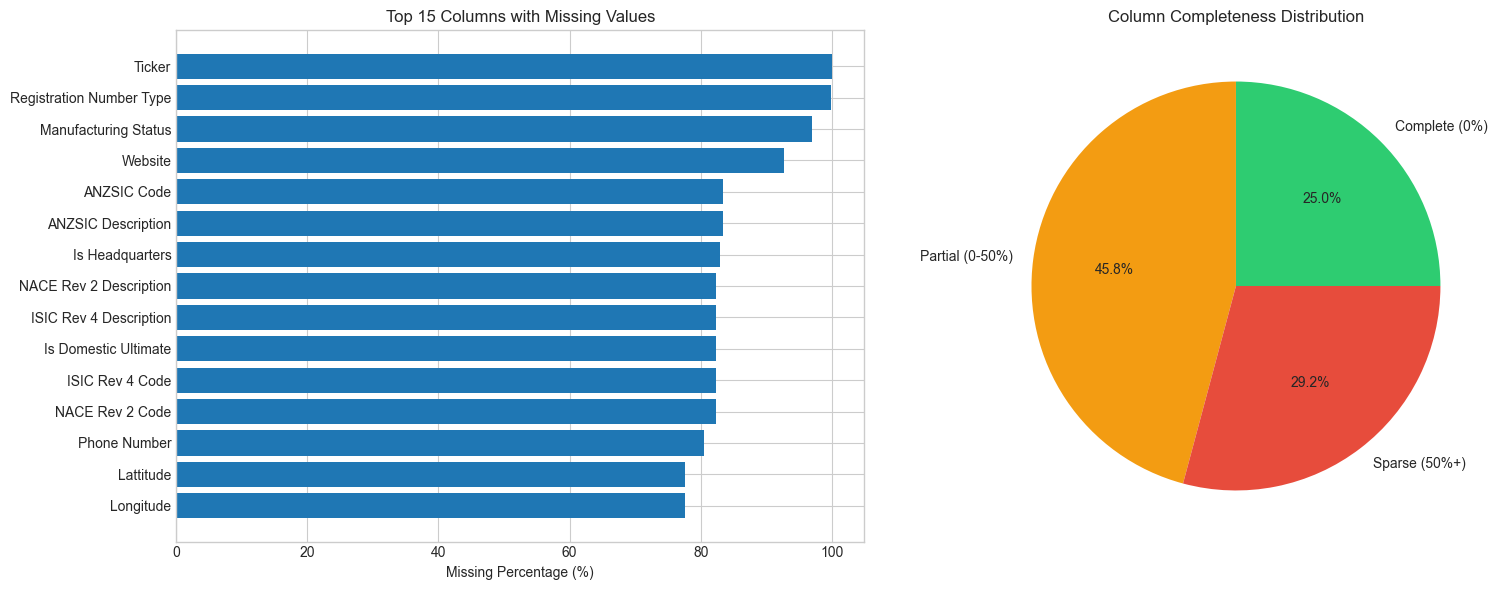

In [131]:
# Visualize missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Missing percentage bar chart (top 15)
top_missing = quality_report.head(15)
axes[0].barh(top_missing['Column'].astype(str), top_missing['Null Percentage'])
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 15 Columns with Missing Values')
axes[0].invert_yaxis()

# Data completeness pie chart
complete_cols = (quality_report['Null Percentage'] == 0).sum()
partial_cols = ((quality_report['Null Percentage'] > 0) & (quality_report['Null Percentage'] < 50)).sum()
sparse_cols = (quality_report['Null Percentage'] >= 50).sum()

axes[1].pie([complete_cols, partial_cols, sparse_cols], 
            labels=['Complete (0%)', 'Partial (0-50%)', 'Sparse (50%+)'],
            autopct='%1.1f%%', colors=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('Column Completeness Distribution')

plt.tight_layout()
plt.show()

## 4. Exploratory Data Analysis (EDA)

### 4.1 Geographic Distribution

In [132]:
# Country distribution
df['Country'] = df['Country'].str.strip().str.upper()
country_dist = df['Country'].value_counts().head(20)

fig = px.bar(x=country_dist.values, y=country_dist.index, orientation='h',
             title='Top 20 Countries by Company Count',
             labels={'x': 'Number of Companies', 'y': 'Country'})
fig.update_layout(height=600)
fig.show()

In [133]:
# Region distribution
if 'Region' in df.columns:
    df['Region'] = df['Region'].str.strip()
    region_dist = df['Region'].value_counts()
    
    fig = px.pie(values=region_dist.values, names=region_dist.index,
                 title='Company Distribution by Region')
    fig.show()

### 4.2 Company Size & Revenue Analysis

In [134]:
# Convert numeric columns
def clean_numeric(col):
    """Clean and convert to numeric"""
    if df[col].dtype == 'object':
        # Remove common non-numeric characters
        cleaned = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    return pd.to_numeric(df[col], errors='coerce')

# Key numeric columns
df['Employees_Total_Clean'] = clean_numeric('Employees Total')
df['Revenue_USD_Clean'] = clean_numeric('Revenue (USD)')
df['Employees_Single_Site_Clean'] = clean_numeric('Employees Single Site')

print("📊 Employee & Revenue Statistics:")
print(df[['Employees_Total_Clean', 'Revenue_USD_Clean', 'Employees_Single_Site_Clean']].describe())

📊 Employee & Revenue Statistics:
       Employees_Total_Clean  Revenue_USD_Clean  Employees_Single_Site_Clean
count               8559.000           8559.000                     8557.000
mean                  22.658        3960698.980                       22.666
std                   99.689       45102121.815                       99.700
min                    0.000              0.000                        0.000
25%                    0.000              0.000                        0.000
50%                    4.000         443445.000                        4.000
75%                   21.000        2099812.000                       21.000
max                 3290.000     2961727200.000                     3290.000


In [135]:
# Revenue distribution (log scale)
revenue_data = df['Revenue_USD_Clean'].dropna()
revenue_data = revenue_data[revenue_data > 0]

fig = px.histogram(x=np.log10(revenue_data), nbins=50,
                   title='Revenue Distribution (Log10 Scale)',
                   labels={'x': 'Log10(Revenue USD)'})
fig.show()

In [136]:
# Create company size segments
def company_size_segment(employees):
    if pd.isna(employees) or employees == 0:
        return 'Unknown'
    elif employees < 10:
        return 'Micro (1-9)'
    elif employees < 50:
        return 'Small (10-49)'
    elif employees < 250:
        return 'Medium (50-249)'
    elif employees < 1000:
        return 'Large (250-999)'
    else:
        return 'Enterprise (1000+)'

df['Company_Size_Segment'] = df['Employees_Total_Clean'].apply(company_size_segment)

# Visualize
size_order = ['Micro (1-9)', 'Small (10-49)', 'Medium (50-249)', 'Large (250-999)', 'Enterprise (1000+)', 'Unknown']
size_dist = df['Company_Size_Segment'].value_counts().reindex(size_order, fill_value=0)

fig = px.bar(x=size_dist.index, y=size_dist.values,
             title='Company Size Distribution',
             labels={'x': 'Size Segment', 'y': 'Number of Companies'},
             color=size_dist.index)
fig.show()

### 4.3 Industry Analysis

In [137]:
# SIC Code Analysis
df['SIC Description'] = df['SIC Description'].str.strip()
industry_dist = df['SIC Description'].value_counts().head(20)

fig = px.bar(x=industry_dist.values, y=industry_dist.index, orientation='h',
             title='Top 20 Industries (SIC Description)',
             labels={'x': 'Number of Companies', 'y': 'Industry'})
fig.update_layout(height=700)
fig.show()

In [138]:
# NAICS Industry Analysis
if 'NAICS Description' in df.columns:
    df['NAICS Description'] = df['NAICS Description'].str.strip()
    naics_dist = df['NAICS Description'].value_counts().head(15)
    
    fig = px.treemap(names=naics_dist.index, parents=[''] * len(naics_dist), values=naics_dist.values,
                     title='Industry Distribution (NAICS) - Treemap')
    fig.show()

### 4.4 Entity & Ownership Analysis

In [139]:
# Entity Type Distribution
if 'Entity Type' in df.columns:
    df['Entity Type'] = df['Entity Type'].str.strip()
    entity_dist = df['Entity Type'].value_counts()
    
    fig = px.pie(values=entity_dist.values, names=entity_dist.index,
                 title='Entity Type Distribution (HQ, Subsidiary, Branch, Single Location)',
                 hole=0.4)
    fig.show()

In [140]:
# Ownership Type
if 'Ownership Type' in df.columns:
    df['Ownership Type'] = df['Ownership Type'].str.strip()
    ownership_dist = df['Ownership Type'].value_counts()
    
    fig = px.pie(values=ownership_dist.values, names=ownership_dist.index,
                 title='Ownership Type Distribution (Private vs Public)')
    fig.show()

### 4.5 IT Infrastructure Analysis

In [141]:
# IT related columns analysis
it_columns = ['IT Budget', 'IT Spend', 'No. of PC', 'No. of Desktops', 'No. of Laptops', 
              'No. of Routers', 'No. of Servers', 'No. of Storage Devices']

it_exists = [col for col in it_columns if col in df.columns]
print(f"IT-related columns in dataset: {it_exists}")

# Check IT data completeness
for col in it_exists:
    non_null = df[col].notnull().sum()
    pct = (non_null / len(df) * 100)
    print(f"{col}: {non_null:,} non-null values ({pct:.1f}%)")

IT-related columns in dataset: ['IT Budget', 'No. of PC', 'No. of Desktops', 'No. of Laptops', 'No. of Routers', 'No. of Servers', 'No. of Storage Devices']
IT Budget: 8,559 non-null values (100.0%)
No. of PC: 8,278 non-null values (96.7%)
No. of Desktops: 8,218 non-null values (96.0%)
No. of Laptops: 7,920 non-null values (92.5%)
No. of Routers: 5,260 non-null values (61.5%)
No. of Servers: 5,210 non-null values (60.9%)
No. of Storage Devices: 5,126 non-null values (59.9%)


## 5. Enhanced Data Cleaning
Handling missing values, standardizing formats, and creating clean numeric columns.

In [142]:
print("🔧 Cleaning numeric columns...")

def clean_numeric_series(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.strip(), errors='coerce')

# Clean key columns (keep NaNs as NaNs initially)
revenue_raw = clean_numeric_series(df['Revenue (USD)'])
employees_raw = clean_numeric_series(df['Employees Total'])

# Create explicit missing value flags
df['Is_Revenue_Missing'] = revenue_raw.isna() | (revenue_raw == 0)
df['Is_Employees_Missing'] = employees_raw.isna() | (employees_raw == 0)


# Prepare for KNN Imputation
print("   Performing KNN Imputation for missing values...")
impute_df = pd.DataFrame({
    'Revenue': revenue_raw.replace(0, np.nan),
    'Employees': employees_raw.replace(0, np.nan)
})

# Log transform for better KNN performance on skewed data
impute_df['Revenue'] = np.log1p(impute_df['Revenue'])
impute_df['Employees'] = np.log1p(impute_df['Employees'])

# Add Entity Type as ordinal feature to help imputation
entity_map_impute = {'Headquarters': 4, 'Single Location': 3, 'Subsidiary': 2, 'Branch': 1}
impute_df['Entity_Ord'] = df['Entity Type'].map(entity_map_impute).fillna(1)

# Scale before KNN
scaler_impute = StandardScaler()
impute_scaled = scaler_impute.fit_transform(impute_df)

# Impute (using 5 neighbors)
knn_imputer = KNNImputer(n_neighbors=5)
impute_filled_scaled = knn_imputer.fit_transform(impute_scaled)

# Inverse transform to get original scale (still log-transformed)
impute_filled_log = scaler_impute.inverse_transform(impute_filled_scaled)

# Inverse transform log (expm1) to get actual values
df['Revenue_USD_Clean'] = np.expm1(impute_filled_log[:, 0])
df['Employees_Total_Clean'] = np.expm1(impute_filled_log[:, 1])

# Fill other numeric columns
df['Employees_Site_Clean'] = clean_numeric_series(df['Employees Single Site']).fillna(0)
df['Corporate_Family_Size'] = clean_numeric_series(df['Corporate Family Members']).fillna(0)

print(f"   Revenue missing/zero: {df['Is_Revenue_Missing'].sum():,} ({df['Is_Revenue_Missing'].mean()*100:.1f}%)")
print(f"   Employees missing/zero: {df['Is_Employees_Missing'].sum():,} ({df['Is_Employees_Missing'].mean()*100:.1f}%)")


🔧 Cleaning numeric columns...
   Performing KNN Imputation for missing values...
   Revenue missing/zero: 3,316 (38.7%)
   Employees missing/zero: 3,132 (36.6%)


## 6. Feature Engineering
Creating derived metrics like Entity Score, Revenue Per Employee, and Data Completeness.

In [143]:
print("🛠 Engineering features...")

# 1. Entity Type Score (Decision Power)
entity_map = {'Headquarters': 4, 'Single Location': 3, 'Subsidiary': 2, 'Branch': 1}
df['Entity_Score'] = df['Entity Type'].map(entity_map).fillna(1)

# 2. Structure
df['Has_Parent'] = df['Parent Company'].notna().astype(int)
df['SIC_2Digit'] = df['SIC Code'].astype(str).str[:2]


# 3. Revenue Per Employee (Productivity)
# Handle potential division by zero if KNN somehow left 0s
df['Revenue_Per_Employee'] = df['Revenue_USD_Clean'] / df['Employees_Total_Clean'].replace(0, np.nan)

# Fill any remaining NaNs with median
rpe_median = df['Revenue_Per_Employee'].median()
df['Revenue_Per_Employee'] = df['Revenue_Per_Employee'].fillna(rpe_median)

# 4. Log Transforms (for clustering skewness)
df['Log_Revenue'] = np.log1p(df['Revenue_USD_Clean'])
df['Log_Employees'] = np.log1p(df['Employees_Total_Clean'])

# 5. Data Completeness Score
df['Data_Completeness'] = (
    (~df['Is_Revenue_Missing']).astype(int) + 
    (~df['Is_Employees_Missing']).astype(int) + 
    df['SIC Code'].notna().astype(int) + 
    df['Entity Type'].notna().astype(int) + 
    df['Region'].notna().astype(int) + 
    df['Country'].notna().astype(int)
) / 6

print("   Created: Entity_Score, Revenue_Per_Employee, Log_Revenue, Log_Employees, Data_Completeness")

🛠 Engineering features...
   Created: Entity_Score, Revenue_Per_Employee, Log_Revenue, Log_Employees, Data_Completeness


## 7. Industry Benchmarking
Comparing company performance against 2-digit SIC industry peers.

In [144]:
print("📊 Calculating industry benchmarks...")

# Aggregation
industry_stats = df.groupby('SIC_2Digit').agg(
    Ind_Revenue_Median=('Revenue_USD_Clean', 'median'),
    Ind_Revenue_Mean=('Revenue_USD_Clean', 'mean'),
    Ind_Employees_Median=('Employees_Total_Clean', 'median'),
    Ind_Employees_Mean=('Employees_Total_Clean', 'mean'),
    Ind_Count=('Revenue_USD_Clean', 'count')
).reset_index()

# Clean Merge: Drop existing columns to prevent duplicates
cols_to_drop = [c for c in industry_stats.columns if c in df.columns and c != 'SIC_2Digit']
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)

# Merge
df = df.merge(industry_stats, on='SIC_2Digit', how='left')

# Calculate Deviations (%)
df['Revenue_vs_Industry'] = np.where(
    df['Ind_Revenue_Median'] > 0,
    (df['Revenue_USD_Clean'] / df['Ind_Revenue_Median'] - 1) * 100,
    0
).clip(-100, 500)

df['Employees_vs_Industry'] = np.where(
    df['Ind_Employees_Median'] > 0,
    (df['Employees_Total_Clean'] / df['Ind_Employees_Median'] - 1) * 100,
    0
).clip(-100, 500)

print(f"   Benchmarked against {len(industry_stats)} industry sectors")

📊 Calculating industry benchmarks...
   Benchmarked against 77 industry sectors


## 8. Multi-Dimensional Clustering
Segmenting companies using K-Means on Size, Structure, and Efficiency.

   Optimal clusters: 8 (Silhouette: 0.5292)


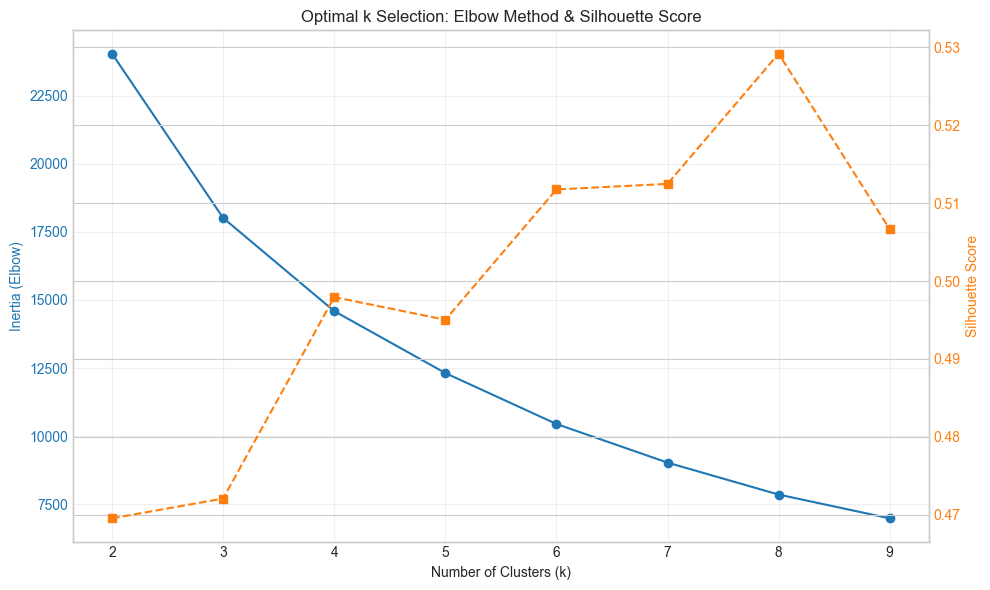

   Assigning clusters with k=8...
   Cluster distribution (Fixed Naming):
Cluster_Name
Tier 6.0 Branch        3066
Tier 5.0 Subsidiary    2636
Tier 7.0 Branch        1329
Tier 4.0 Subsidiary     713
Tier 8.0 Branch         554
Tier 3.0 Subsidiary     257
Tier 2.0 Subsidiary       3
Tier 1.0 Subsidiary       1
Name: count, dtype: int64
      Tier 4.0 Subsidiary       (ID 0): 713 companies | Median Rev: $5,895,716
      Tier 7.0 Branch           (ID 1): 1,329 companies | Median Rev: $917,635
      Tier 5.0 Subsidiary       (ID 2): 2,636 companies | Median Rev: $1,491,089
      Tier 1.0 Subsidiary       (ID 3): 1 companies | Median Rev: $517,593,000
      Tier 8.0 Branch           (ID 4): 554 companies | Median Rev: $74,409
      Tier 6.0 Branch           (ID 5): 3,066 companies | Median Rev: $1,463,100
      Tier 3.0 Subsidiary       (ID 6): 257 companies | Median Rev: $14,967,120
      Tier 2.0 Subsidiary       (ID 7): 3 companies | Median Rev: $290,248,462


In [145]:
# Prepare clustering features
cluster_features = ['Log_Revenue', 'Log_Employees', 'Entity_Score', 'Has_Parent', 'Revenue_Per_Employee']
X_cluster = df[cluster_features].copy()

# Handle infinities and NaNs
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan)
X_cluster = X_cluster.fillna(X_cluster.median())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Find optimal k using Elbow Method and Silhouette Score
best_k = 4
best_score = -1
inertia_list = []
silhouette_list = []
k_range = range(2, 10)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    # Metrics
    inertia_list.append(kmeans_temp.inertia_)
    score = silhouette_score(X_scaled, labels_temp)
    silhouette_list.append(score)
    
    # Update best k
    if score > best_score:
        best_score = score
        best_k = k

print(f"   Optimal clusters: {best_k} (Silhouette: {best_score:.4f})")

# Visualize Elbow Method and Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(k_range, inertia_list, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_list, marker='s', linestyle='--', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Optimal k Selection: Elbow Method & Silhouette Score')
fig.tight_layout()
plt.show()


# Final Clustering
print(f"   Assigning clusters with k={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


def get_cluster_context(df_data, k):
    """
    Dynamically names clusters using MODE (Most Frequent) for Entity Type
    to avoid averaging dilution.
    """
    # 1. Calculate Centroids & Dominant Type
    # 使用 lambda x: x.mode()[0] 来提取众数（该组中最常见的类型）
    profiles = df_data.groupby('Cluster').agg({
        'Revenue_USD_Clean': 'median',
        'Employees_Total_Clean': 'median',
        'Entity_Score': lambda x: x.mode().iloc[0] if not x.mode().empty else x.mean() 
    }).reset_index()
    
    # 2. Assign Tiers based on Revenue Rank (1 = Highest Revenue)
    profiles['Rank'] = profiles['Revenue_USD_Clean'].rank(ascending=False, method='min').astype(int)
    
    # 3. Generate Dynamic Names
    def generate_name(row):
        # Tier Part
        tier = f"Tier {row['Rank']}"
        
        # Structure Part - 现在这是众数，是整数 (4, 3, 2, 1)
        score = row['Entity_Score']
        
        if score >= 4:       # 主要是总部
            structure = "HQ"
        elif score >= 3:     # 主要是独立地点
            structure = "Indep/Strategic" 
        elif score >= 2:     # 主要是子公司
            structure = "Subsidiary"
        else:                # 主要是分支机构
            structure = "Branch"
            
        return f"{tier} {structure}"

    profiles['Cluster_Name'] = profiles.apply(generate_name, axis=1)
    
    return profiles.set_index('Cluster')['Cluster_Name'].to_dict()

# --- 重新运行映射 ---
cluster_names_map = get_cluster_context(df, best_k)
df['Cluster_Name'] = df['Cluster'].map(cluster_names_map)

print(f"   Cluster distribution (Fixed Naming):")
print(df['Cluster_Name'].value_counts())

cluster_counts = df['Cluster'].value_counts()

for cluster_id in sorted(df['Cluster'].unique()):
    name = cluster_names_map[cluster_id]
    count = cluster_counts[cluster_id]
    med_rev = df[df['Cluster'] == cluster_id]['Revenue_USD_Clean'].median()
    print(f"      {name:<25} (ID {cluster_id}): {count:,} companies | Median Rev: ${med_rev:,.0f}")


## 9. B2B Lead Scoring & Risk Detection
Prioritizing targets and flagging high-risk entities.

In [146]:
print("💰 Calculating Lead Scores & Risks...")

def calculate_lead_score(row):
    score = 0
    # Revenue (40)
    rev = row['Revenue_USD_Clean']
    if rev >= 1e7: score += 40
    elif rev >= 1e6: score += 30
    elif rev >= 1e5: score += 20
    else: score += 5
    
    # Entity (25)
    score += row['Entity_Score'] * 6.25
    
    # Growth/Efficiency (20)
    rpe = row['Revenue_Per_Employee']
    if rpe >= 5e5: score += 20
    elif rpe >= 1e5: score += 15
    else: score += 5
    
    # Data Quality (15)
    score += row['Data_Completeness'] * 15
    return min(100, max(0, score))

df['Lead_Score'] = df.apply(calculate_lead_score, axis=1)
df['Lead_Tier'] = pd.cut(df['Lead_Score'], bins=[0, 30, 50, 70, 100], labels=['Cold', 'Warm', 'Hot', 'Priority'])

# Risk Detection
df['Risk_Shell'] = (df['Revenue_USD_Clean'] > 1e5) & (df['Employees_Total_Clean'] == 0)
df['Risk_DataQuality'] = df['Data_Completeness'] < 0.5
df['Risk_OrphanSub'] = (df['Entity Type'] == 'Subsidiary') & (df['Has_Parent'] == 0)

# Isolation Forest Anomaly
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso.fit_predict(X_scaled) # -1 is anomaly
df['Anomaly_Label'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Combined Risk Score
df['Risk_Flags'] = (
    df['Risk_Shell'].astype(int) + 
    df['Risk_DataQuality'].astype(int) + 
    df['Risk_OrphanSub'].astype(int) + 
    (df['Anomaly'] == -1).astype(int)
)

print("   Lead Score Distribution:")
print(df['Lead_Tier'].value_counts())
print(f"   Anomalies detected: {(df['Anomaly'] == -1).sum()}")

💰 Calculating Lead Scores & Risks...
   Lead Score Distribution:
Lead_Tier
Hot         6016
Priority    1637
Warm         824
Cold          82
Name: count, dtype: int64
   Anomalies detected: 428


## 10. Visualization of Insights

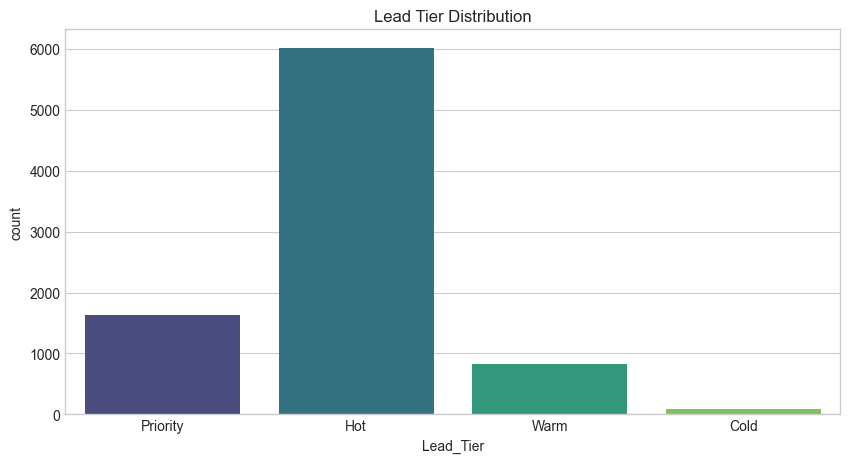

In [147]:
# 1. Cluster Visualization
fig = px.scatter(
    df, x='Log_Revenue', y='Log_Employees', 
    color='Cluster_Name', hover_data=['Revenue (USD)', 'Employees Total'],
    title='Company Clusters: Revenue vs Employees'
)
fig.show()

# 2. Lead Tier Distribution
plt.figure(figsize=(10, 5))
sns.countplot(df, x='Lead_Tier', palette='viridis', order=['Priority', 'Hot', 'Warm', 'Cold'])
plt.title('Lead Tier Distribution')
plt.show()

## 11. Export Results

In [148]:
output_cols = [
    'DUNS Number ', 'Company Sites', 'Country', 'Region', 'Entity Type',
    'SIC Code', 'SIC Description', 'Employees_Total_Clean', 'Revenue_USD_Clean',
    'Is_Revenue_Missing', 'Is_Employees_Missing',
    'Entity_Score', 'Has_Parent', 'Revenue_Per_Employee', 'Data_Completeness',
    'Revenue_vs_Industry', 'Employees_vs_Industry',
    'Cluster', 'Cluster_Name',
    'Lead_Score', 'Lead_Tier',
    'Anomaly_Label', 'Risk_Shell', 'Risk_DataQuality', 'Risk_OrphanSub', 'Risk_Flags'
]

# Save only existing columns
valid_cols = [c for c in output_cols if c in df.columns]
df[valid_cols].to_csv('company_segmentation_results.csv', index=False)
print("💾 Results saved to 'company_segmentation_results.csv'")

💾 Results saved to 'company_segmentation_results.csv'


## 12. AI-Powered Insights
We integrate Large Language Models (Gemini API) to generate interpretable business intelligence:
1.  **Cluster Personas**: Automatically naming and describing market segments.
2.  **Anomaly Explanation**: Rationalizing why specific data points are flagged as outliers.
3.  **Battle Reports**: Generating actionable sales strategies for specific leads.

In [153]:
%env GEMINI_API_KEY=[FILL IN YOUR API KEY HERE]

env: GEMINI_API_KEY=[FILL IN YOUR API KEY HERE]


In [150]:
"""
LLM Insights Module for Company Intelligence Analysis
SDS Datathon 2026

This module provides AI-powered insight generation using Google Gemini API.
It offers three main capabilities:
- Cluster persona generation
- Anomaly explanation  
- Company comparison analysis

Usage:
    from llm_insights import CompanyInsightGenerator
    llm = CompanyInsightGenerator(api_key='your-key')
    insight = llm.generate_cluster_insight(cluster_id, profile)

Requires: GEMINI_API_KEY environment variable or pass api_key directly.
"""

import os
import google.generativeai as genai
from typing import Dict, List, Any
import pandas as pd
import json


class CompanyInsightGenerator:
    """
    Generates intelligent insights for company analysis using Large Language Models.
    Defaults to Google Gemini API.
    """
    
    def __init__(self, api_key: str = None, model_name: str = 'gemini-3-flash-preview'):
        self.api_key = api_key or os.getenv("GEMINI_API_KEY")
        self.enabled = False
        
        if not self.api_key:
            print("⚠️ Warning: GEMINI_API_KEY not found. Intelligent features will run in mock mode.")
            print("To enable: import os; os.environ['GEMINI_API_KEY'] = 'your_key'")
        else:
            try:
                genai.configure(api_key=self.api_key)
                self.model = genai.GenerativeModel(model_name)
                self.enabled = True
                print(f"✅ LLM Insight Generator initialized with {model_name}")
            except Exception as e:
                print(f"❌ Failed to initialize LLM: {e}")

    def generate_cluster_insight(self, cluster_id: int, profile: Dict[str, Any], key_features: List[str] = None) -> str:
        """Generates a business persona and strategic analysis for a company cluster."""
        if not self.enabled:
            return f"Cluster {cluster_id} Analysis (Mock): This cluster contains {profile.get('Size', 'N/A')} companies. Enable LLM for detailed persona."
        
        prompt = f"""
        Act as a Senior Business Strategy Consultant. Analyze the following data profile for a group of companies (Cluster {cluster_id}).
        
        DATA PROFILE:
        - Size: {profile.get('Size', 'N/A')} companies ({profile.get('Percentage', 'N/A')} of total)
        - Median Revenue: ${profile.get('Median_Revenue_USD', 0):,.2f}
        - Median Employees: {profile.get('Median_Employees', 0):,.0f}
        - Top Region: {profile.get('Top_Region', 'N/A')}
        - Top Industry: {profile.get('Top_Industry', 'N/A')}
        - Primary Entity Type: {profile.get('Top_Entity_Type', 'N/A')}
        
        TASK:
        1. create a short, professional "Persona Name" for this cluster (e.g., "Asian Tech SMBs", "Global Enterprise HQs").
        2. Write a 2-sentence "Executive Summary" defining their key operational characteristics.
        3. Identify 3 "Strategic Needs" these companies likely have (e.g., cloud migration, credit lines, export compliance).
        
        OUTPUT FORMAT:
        **Persona:** [Name]
        **Summary:** [Text]
        **Strategic Needs:**
        - [Need 1]
        - [Need 2]
        - [Need 3]
        """
        
        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error generating insight: {e}"

    def explain_anomaly(self, company_row: pd.Series, cluster_avg: pd.Series) -> str:
        """Explains why a specific company is flagged as an anomaly compared to its cluster peers."""
        if not self.enabled:
            return "Anomaly Explanation (Mock): This company's metrics deviate significantly from the cluster average."

        prompt = f"""
        Act as a Risk Assessment Analyst. A company has been flagged as an 'Anomaly' by our Isolation Forest algorithm.
        Explain WHY based on the comparison below.
        
        COMPANY DATA:
        - Name/ID: {company_row.get('DUNS Number ', 'Unknown')}
        - Revenue: ${company_row.get('Revenue_USD_Clean', 0):,.2f}
        - Employees: {company_row.get('Employees_Total_Clean', 0):,.0f}
        - Region: {company_row.get('Region', 'N/A')}
        
        CLUSTER AVERAGE ({company_row.get('Cluster_Name', 'Unknown')}):
        - Avg Revenue: ${cluster_avg.get('Revenue_USD_Clean', 0):,.2f}
        - Avg Employees: {cluster_avg.get('Employees_Total_Clean', 0):,.0f}
        
        TASK:
        1. Identify the specific metric(s) that look unusual (too high? too low? mismatch?).
        2. Assess if this looks like a "High Performance" outlier (good) or a "Data Error/Financial Risk" outlier (bad).
        3. Provide a one-sentence recommendation for the analyst.
        
        Keep it concise (approx 100 words).
        """
        
        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error explaining anomaly: {e}"

    def compare_companies(self, company_a: pd.Series, company_b: pd.Series) -> str:
        """Compares two companies and suggests competitive insights."""
        if not self.enabled:
            return "Company Comparison (Mock): Enable LLM to see detailed competitive analysis."

        prompt = f"""
        Compare these two companies for a sales strategy report.
        
        Company A:
        - Employees: {company_a.get('Employees_Total_Clean', 0)}
        - Revenue: ${company_a.get('Revenue_USD_Clean', 0):,.2f}
        - Region: {company_a.get('Region', 'N/A')}
        - Industry: {company_a.get('SIC Description', 'N/A')}
        
        Company B:
        - Employees: {company_b.get('Employees_Total_Clean', 0)}
        - Revenue: ${company_b.get('Revenue_USD_Clean', 0):,.2f}
        - Region: {company_b.get('Region', 'N/A')}
        - Industry: {company_b.get('SIC Description', 'N/A')}
        
        TASK:
        1. Highlight the biggest difference between them.
        2. Suggest which one is the "Leader" and which is the "Challenger" (or if they are peers).
        """
        
        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            return f"Error comparing companies: {e}"

    def generate_action_report(self, company_row: pd.Series) -> Dict[str, str]:
        """
        Generates a 'Battle Report' (Verdict, Reason, Risk, Action) for a company.
        Returns a dictionary.
        """
        if not self.enabled:
            return {
                "Method": "LLM-Based (Mock)",
                "Verdict": "🤖 AI VERDICT (Simulated)",
                "Reason": "Enable LLM to generate natural language analysis.",
                "Risk": "AI would identify risks here.",
                "Action": "Enable LLM for specific recommendations."
            }

        prompt = f'''
        Act as a Senior Sales & Risk Analyst. Analyze this company for our B2B Sales Team.
        
        COMPANY DATA:
        - Name: {company_row.get('DUNS Number ', 'Unknown')}
        - Cluster: {company_row.get('Cluster_Name', 'Unknown')}
        - Revenue: ${company_row.get('Revenue_USD_Clean', 0):,.0f}
        - Employees: {company_row.get('Employees_Total_Clean', 0):,.0f}
        - Lead Score: {company_row.get('Lead_Score', 0)} ({company_row.get('Lead_Tier', 'Unknown')})
        - Risk Flags: {company_row.get('Risk_Flags', 0)}
        - Details: Anomaly={company_row.get('Anomaly_Label', 'N/A')}, Shell={company_row.get('Risk_Shell', False)}
        
        OUTPUT JSON FORMAT:
        {{
            "Verdict": "Short powerful phrase (e.g., 'Prime Acquisition Target' or 'Stay Away')",
            "Reason": "One sharp sentence explaining why, highlighting nuances.",
            "Risk": "Assessment of risk, detecting subtleties (e.g., 'Revenue seems too high for team size').",
            "Action": "Specific recommendation (e.g., 'Send VP of Sales', 'Request Financial Audit')."
        }}
        
        Return ONLY VALID JSON.
        '''
        
        try:
            response = self.model.generate_content(prompt)
            text = response.text.strip()
            # Clean potential markdown
            if text.startswith("```json"):
                text = text[7:]
            if text.endswith("```"):
                text = text[:-3]
            return json.loads(text.strip())
        except Exception as e:
            return {"Method": "LLM-Based", "Error": str(e)}


In [151]:
# Initialize AI Generator
# Ensure GEMINI_API_KEY is set in environment variables
try:
    llm = CompanyInsightGenerator()
    print("✅ AI Engine Initialized")
except Exception as e:
    print(f"⚠️ AI Initialization Failed: {e}")

✅ LLM Insight Generator initialized with gemini-3-flash-preview
✅ AI Engine Initialized


### 12.1 Generate Battle Report (Example)
Simulating a 'Battle Report' for a high-priority lead.

In [152]:
if llm.enabled:
    # Pick a high-value sample
    sample_company = df[df['Lead_Tier'] == 'Priority'].iloc[3]
    
    print(f"⚔️ Generatng Battle Report for: {sample_company['DUNS Number ']}...")
    report = llm.generate_action_report(sample_company)
    
    print(report)
    print("\n" + "="*40)
    print(f"🎯 VERDICT: {report.get('Verdict')}")
    print("="*40)
    print(f"⚡ ACTION:  {report.get('Action')}")
    print(f"📝 REASON:  {report.get('Reason')}")
    print(f"⚠️ RISK:    {report.get('Risk')}")
else:
    print("Skipping AI demo (No API Key detected)")

⚔️ Generatng Battle Report for: 638031169...
{'Method': 'LLM-Based', 'Error': '429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-3-flash\nPlease retry in 41.568335565s. [links {\n  description: "Learn more about Gemini API quotas"\n  url: "https://ai.google.dev/gemini-api/docs/rate-limits"\n}\n, violations {\n  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"\n  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"\n  quota_dimensions {\n    key: "model"\n    value: "gemini-3-flash"\n  }\n  quota_dimensions {\n    key: "location"\n    value: "global"\n  }\n  quota_value: 20\n}\n, retry_delay {\n  seconds: 41\n}\n]'}

🎯 VERDICT